# Project_1 : Text Classification

## 1. Itroduction

영어 문장에 대한 긍정/부정 리뷰를 구분하는 text classification task입니다.

### 1.1 사용 모델

* Bert
* RoBerta : 테스트 결과 가장 성능이 좋게 나왔다.
* Bart
* XLNet



### 1.2 모델 선정 기준
 
 * hugging face의 존재하는 모델이며, 모델의 클래스 중 SequenceClassification 가 있는 경우 
 * 최근에 나온 모델이며, 성능이 좋다고 평가 받는 모델들

* 유튜브 자료(모델 설명) : https://www.youtube.com/watch?v=v7diENO2mEA

## 2. Library Load and Download

In [1]:
!pip install transformers
!pip install pytorch-lightning
!pip install sentencepiece
!pip install bertviz
!pip install plotly
!pip install pyyaml==5.4.1

     |████████████████████████████████| 3.1 MB 7.2 MB/s 
     |████████████████████████████████| 3.3 MB 43.0 MB/s 
     |████████████████████████████████| 895 kB 36.1 MB/s 
     |████████████████████████████████| 56 kB 4.9 MB/s 
     |████████████████████████████████| 596 kB 51.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 925 kB 7.7 MB/s 
     |████████████████████████████████| 125 kB 58.6 MB/s 
     |████████████████████████████████| 829 kB 37.1 MB/s 
     |████████████████████████████████| 329 kB 50.3 MB/s 
     |████████████████████████████████| 1.3 MB 49.1 MB/s 
     |████████████████████████████████| 271 kB 59.7 MB/s 
     |████████████████████████████████| 160 kB 59.9 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=04c642cb42ab2fcb3f5b7560637188238fa072aa16f072e47910a3de9e703cb6
  Store

In [2]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
import json
import pandas as pd
import numpy as np
import torch
torch.cuda.empty_cache()
from pathlib import Path # 파일시스템의 경로를 단순한 문자열이 아닌 객체로 다루게 하는 것
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from termcolor import colored
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim



from transformers import (
    AdamW,
    RobertaForSequenceClassification,
    RobertaModel,
    RobertaTokenizer
)
from tqdm.auto import tqdm
from bertviz import head_view

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import gc


import warnings

warnings.filterwarnings(action='ignore') 
from plotly import graph_objs as go

from collections import Counter
import plotly.express as px


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10


In [4]:
pl.seed_everything(42)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Global seed set to 42


## 2. EDA

### 2.1 data_load

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:

def load_data_file(filename):
  train_1ist = []
  with open('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/'+ str(filename), 'r', encoding='utf-8') as f:
    for line in f.readlines():
      train_1ist.append(line.lower()[:-1]) 
      f.close()
      
  data = pd.DataFrame(data=train_1ist, columns=['Id'])
  #labels = [[int(filename[-1])] for i in range(len(data))]
  data['label'] = int(filename[-1])
  return data



In [7]:
train_df = pd.concat([load_data_file('sentiment.train.0'), load_data_file('sentiment.train.1')], axis=0)
val_df = pd.concat([load_data_file('sentiment.dev.0'), load_data_file('sentiment.dev.1')], axis=0)

In [8]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/test_no_label.csv')

In [25]:
train_df=train_df.reset_index().drop('index',axis=1)
val_df = val_df.reset_index().drop('index', axis=1)

In [10]:
# roberta-base : accuray -> 98.888
# roberta-large : accuary -> 98.89
MODEL_NAME = 'roberta-large'

tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/482 [00:00<?, ?B/s]

### 2.2 Data EDA

### 2.2.

In [11]:
text_token_counts = []

for row in tqdm(train_df.Id):
    text_token_count = len(tokenizer.encode(row))
    text_token_counts.append(text_token_count)


  0%|          | 0/443259 [00:00<?, ?it/s]

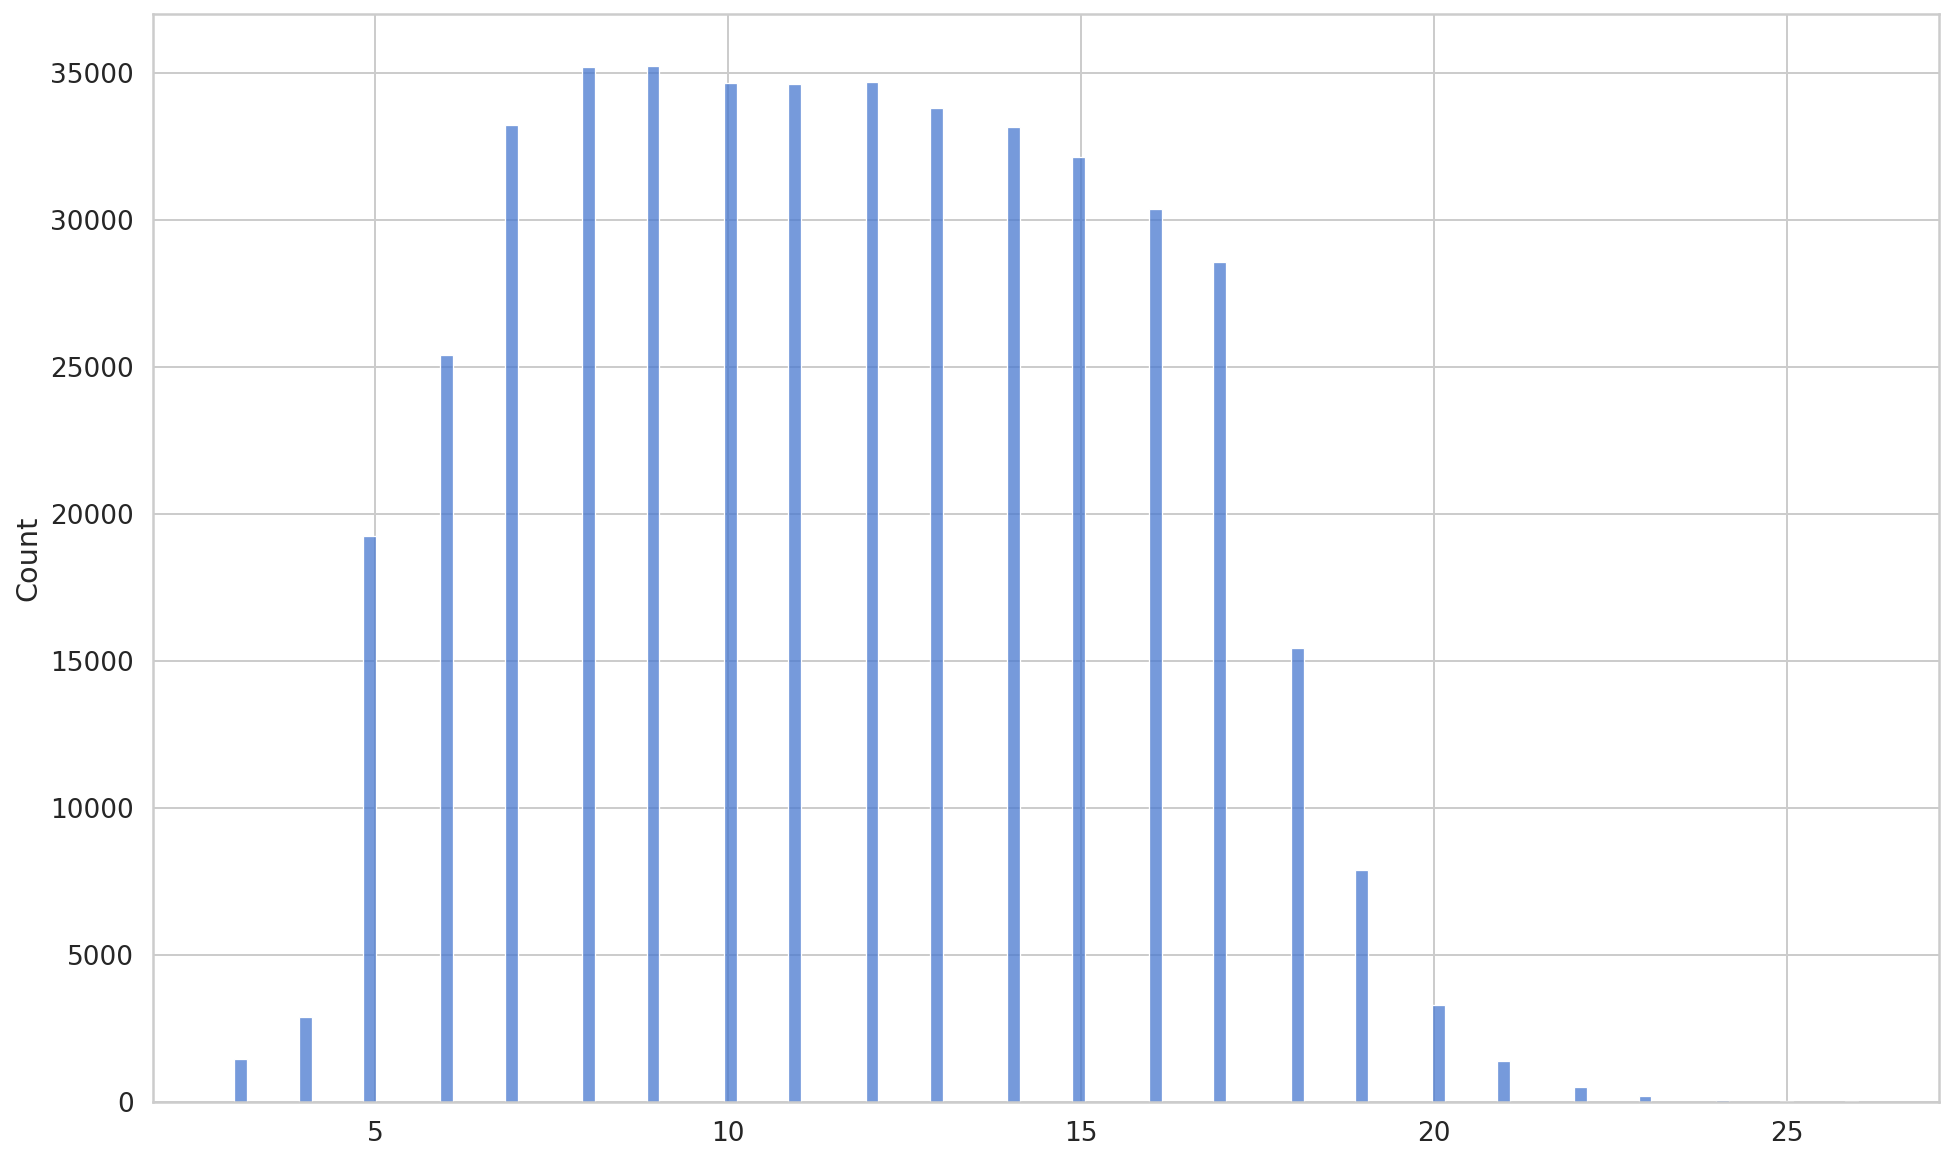

In [44]:
sns.histplot(text_token_counts)

문장의 길이가 전체적으로 짧다.

In [13]:
display(train_df.head(2))
display(val_df.head(2))
display(test_df.head(2))


,Id,label
0,i was sadly mistaken .,0
1,"so on to the hoagies , the italian is general ...",0


,Id,label
0,windows have n't been cleaned in years you can...,0
1,waitresses are slow .,0


,Id
0,it 's a whole new experience and new flavors e...
1,so disappointing from an old favorite .


In [11]:
temp = train_df.groupby('label').count().reset_index().sort_values(by='Id',ascending=False)
display(temp.style.background_gradient(cmap='Blues'))

from plotly import graph_objs as go

fig = go.Figure(go.Funnelarea(
    text =temp.label,
    values = temp.Id,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()




,label,Id
1,1,266041
0,0,177218


In [15]:
temp = val_df.groupby('label').count().reset_index().sort_values(by='Id',ascending=False)
temp.style.background_gradient(cmap='Blues')

,label,Id
0,0,2000
1,1,2000


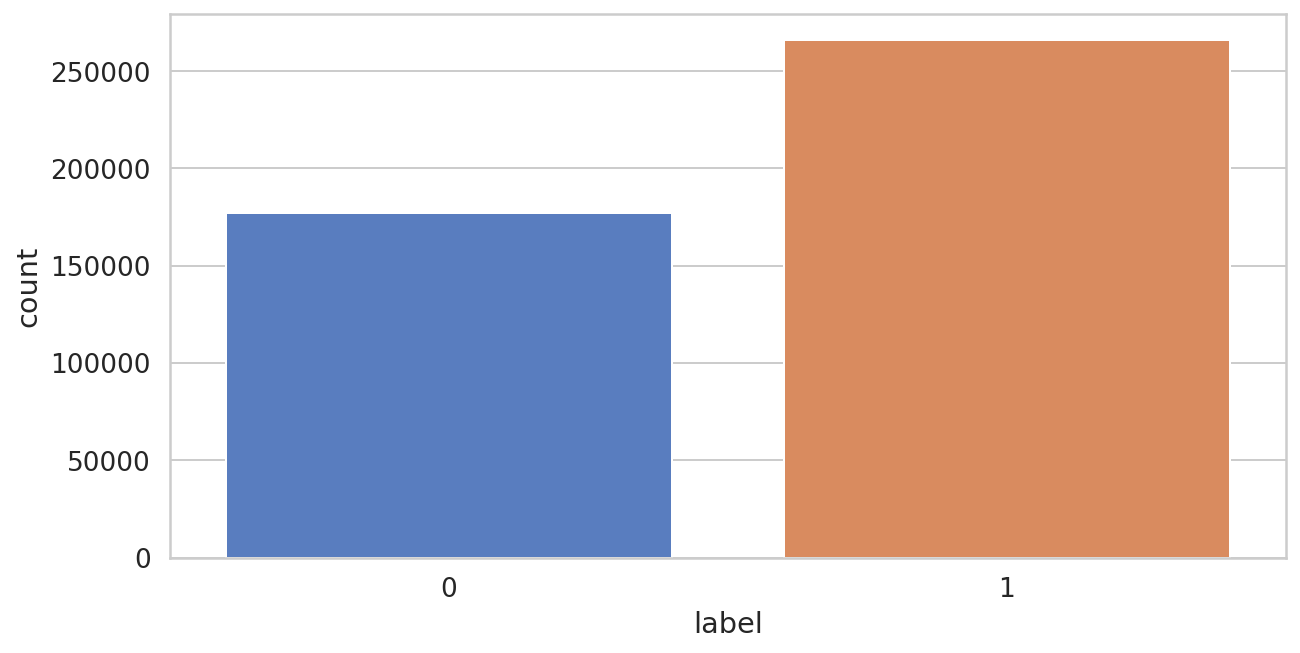

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(data=train_df, x='label')

In [12]:
from collections import Counter
import plotly.express as px

train_df['temp_list'] = train_df['Id'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
display(temp.style.background_gradient(cmap='Blues'))

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Train Id', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

,Common_words,count
0,.,346292
1,the,161149
2,and,125512
3,i,96490
4,!,90030
5,",",85969
6,is,74024
7,was,71592
8,a,69464
9,to,54813


In [82]:
val_df['temp_list'] = val_df['Id'].apply(lambda x:str(x).split())
top = Counter([item for sublist in val_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
display(temp.style.background_gradient(cmap='Greens'))

fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in Validation Id', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

,Common_words,count
0,the,1480
1,and,1028
2,i,954
3,is,748
4,was,669
5,to,574
6,a,556
7,not,532
8,this,486
9,it,413


In [81]:
test_df['temp_list'] = test_df['Id'].apply(lambda x:str(x).split())
top = Counter([item for sublist in test_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
display(temp.style.background_gradient(cmap='Reds'))



,Common_words,count
0,the,461
1,and,357
2,i,267
3,is,233
4,was,215
5,a,179
6,to,168
7,not,154
8,it,134
9,this,123


* n't를 not으로 전처리하는 작업이 필요해 보인다.
* 특수문자 ., !, ? 등을 제거해야할거같다


In [45]:
train_df

,Id,label,temp_list
0,i was sadly mistaken .,0,"[sadly, mistaken, .]"
1,"so on to the hoagies , the italian is general ...",0,"[hoagies, ,, italian, general, run, mill, .]"
2,minimal meat and a ton of shredded lettuce .,0,"[minimal, meat, ton, shredded, lettuce, .]"
3,nothing really special & not worthy of the $ _...,0,"[nothing, really, special, &, worthy, $, _num_..."
4,"second , the steak hoagie , it is atrocious .",0,"[second, ,, steak, hoagie, ,, atrocious, .]"
...,...,...,...
266036,love these donuts !,1,"[love, donuts, !]"
266037,lots of smiles from everyone .,1,"[lots, smiles, everyone, .]"
266038,the donuts are delicious .,1,"[donuts, delicious, .]"
266039,fresh in the morning and conveniently priced .,1,"[fresh, morning, conveniently, priced, .]"


* 불용어를 제거한뒤 문자 카운트

In [13]:
top = Counter([item for sublist in train_df['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]

temp.columns = ['Common_words','count']
display(temp.style.background_gradient(cmap='Purples'))
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

,Common_words,count
1,the,161149
2,and,125512
3,i,96490
4,!,90030
5,",",85969
6,is,74024
7,was,71592
8,a,69464
9,to,54813
10,it,50615


TypeError: ignored

In [56]:
Positive_sent = train_df[train_df['label']==1]
Negative_sent = train_df[train_df['label']==0]

In [58]:
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
display(temp_positive.style.background_gradient(cmap='Greens'))
fig = px.bar(temp_positive, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

,Common_words,count
0,.,189811
1,!,74747
2,",",49038
3,great,44804
4,good,28531
5,food,25773
6,place,24189
7,service,22599
8,love,16632
9,friendly,14669


In [59]:
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
display(temp_negative.style.background_gradient(cmap='Reds'))

fig = px.bar(temp_negative, x="count", y="Common_words", title='Most Commmon Positive Words', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

,Common_words,count
1,",",36931
2,_num_,21050
3,n't,18456
4,!,15283
5,service,10325
6,place,8787
7,food,8583
8,'s,6830
9,would,6544
10,back,6087


In [99]:
def unique_words(df, col="Id", title="Distribution of number of unique words"):
  fig,ax=plt.subplots(1,2,figsize=(12,7))
  colors = {
        1: "green",
        0 : "red"
        
    }
  for _, i in enumerate([0, 1]):
      new=df[df['label']==i][col].map(lambda x: len(set(x.split())))
      sns.distplot(new.values,ax=ax[_],color=colors[i])
      ax[_].set_title(i)
  fig.suptitle(title)
  fig.show()

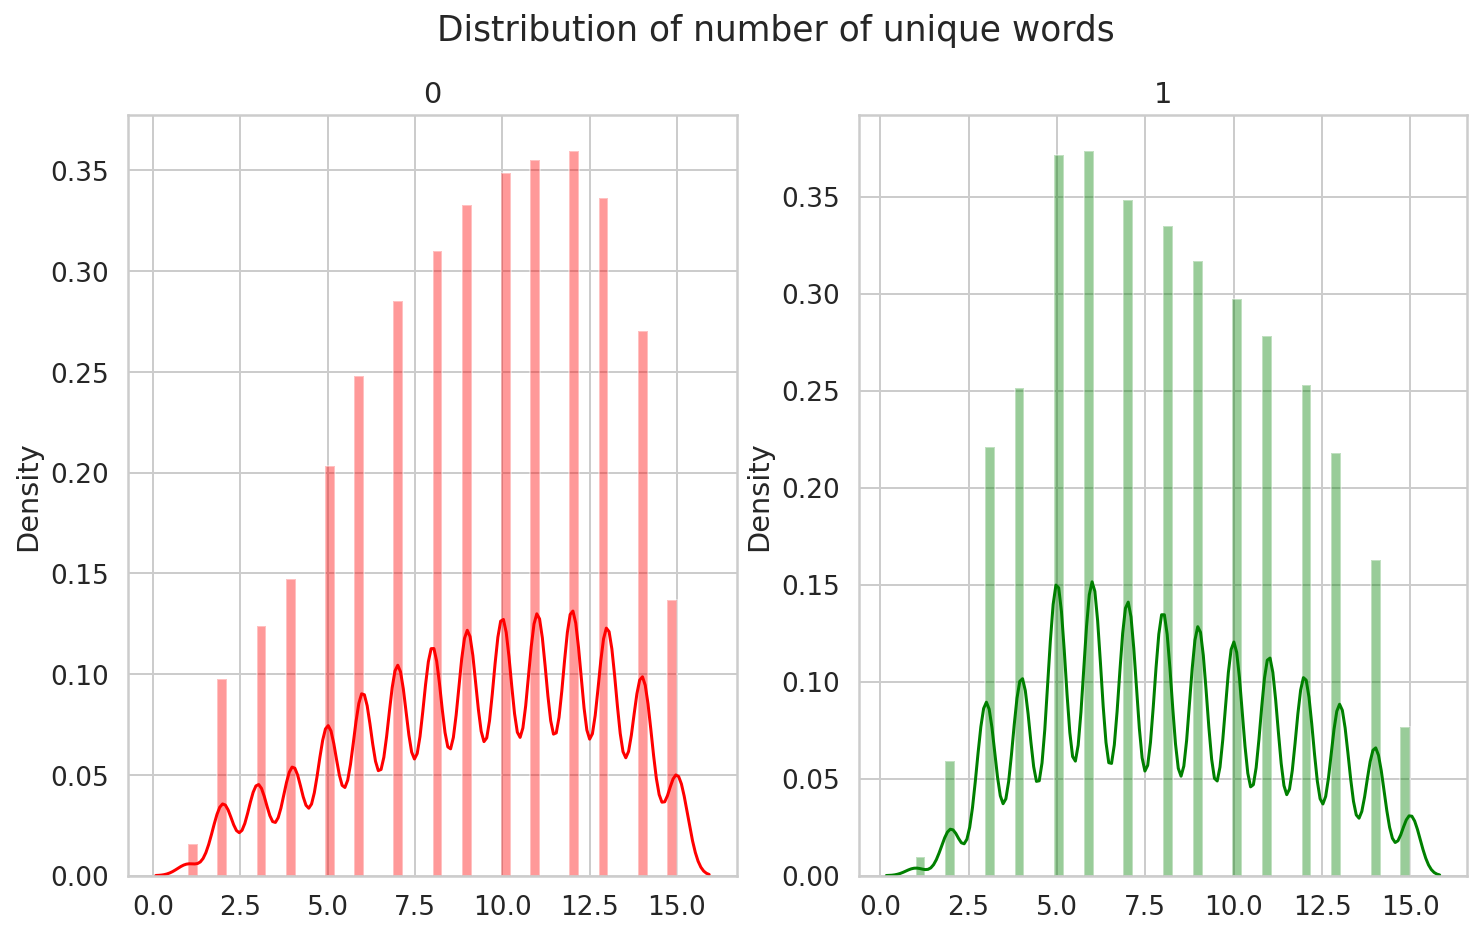

In [90]:
unique_words(train_df)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:20]
    
def plot_n_grams(df, size=2, 
                 title="Common bigrams in selected text",
                 label="label",
                 column="Id"):
    colors = {
        1 : "green",
        0 : "red"}
    
    
    fig,ax=plt.subplots(1,2,figsize=(15,10))
    for _, i in enumerate([0, 1]):
        new=df[df[label]==i][column]
        top_n_bigrams=get_top_ngram(new,size)[:20]
        x,y=map(list,zip(*top_n_bigrams))
        sns.barplot(x=y,y=x,ax=ax[_],color=colors[i])
        ax[_].set_title(i)
    
    fig.suptitle(title)
    fig.show()
   


In [15]:
def plot_n_grams_test(df, title="Common bigrams in selected text", column="Id"):

    
    fig,ax=plt.subplots(1,2,figsize=(15,10))

    new=df[column]
    top_n_bigrams=get_top_ngram(new,1)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x,ax=ax[0],color='black')
    top_n_bigrams=get_top_ngram(new,2)[:20]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x,ax=ax[1],color='gray')
        
    fig.suptitle(title)
    fig.show()
   


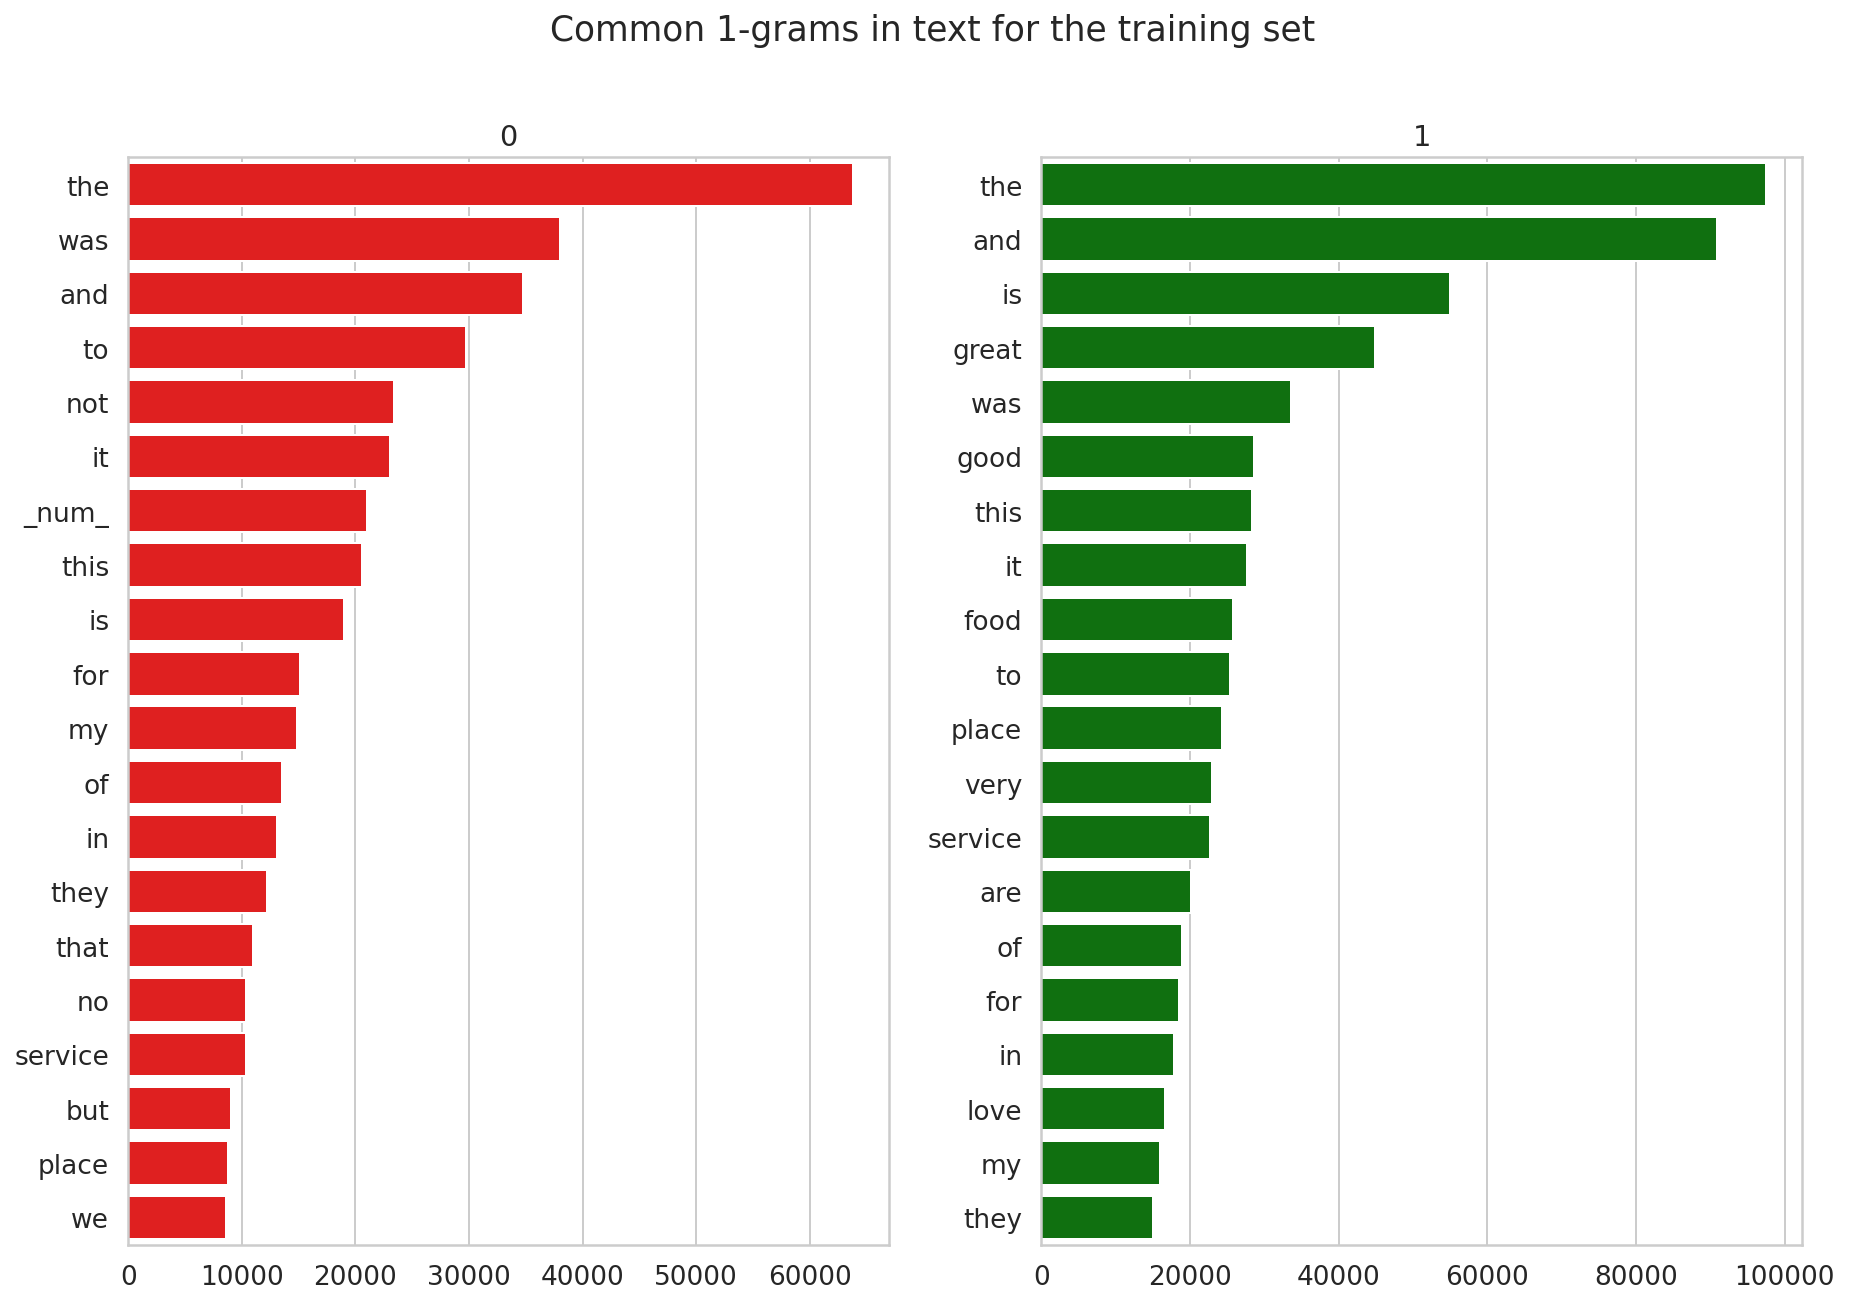

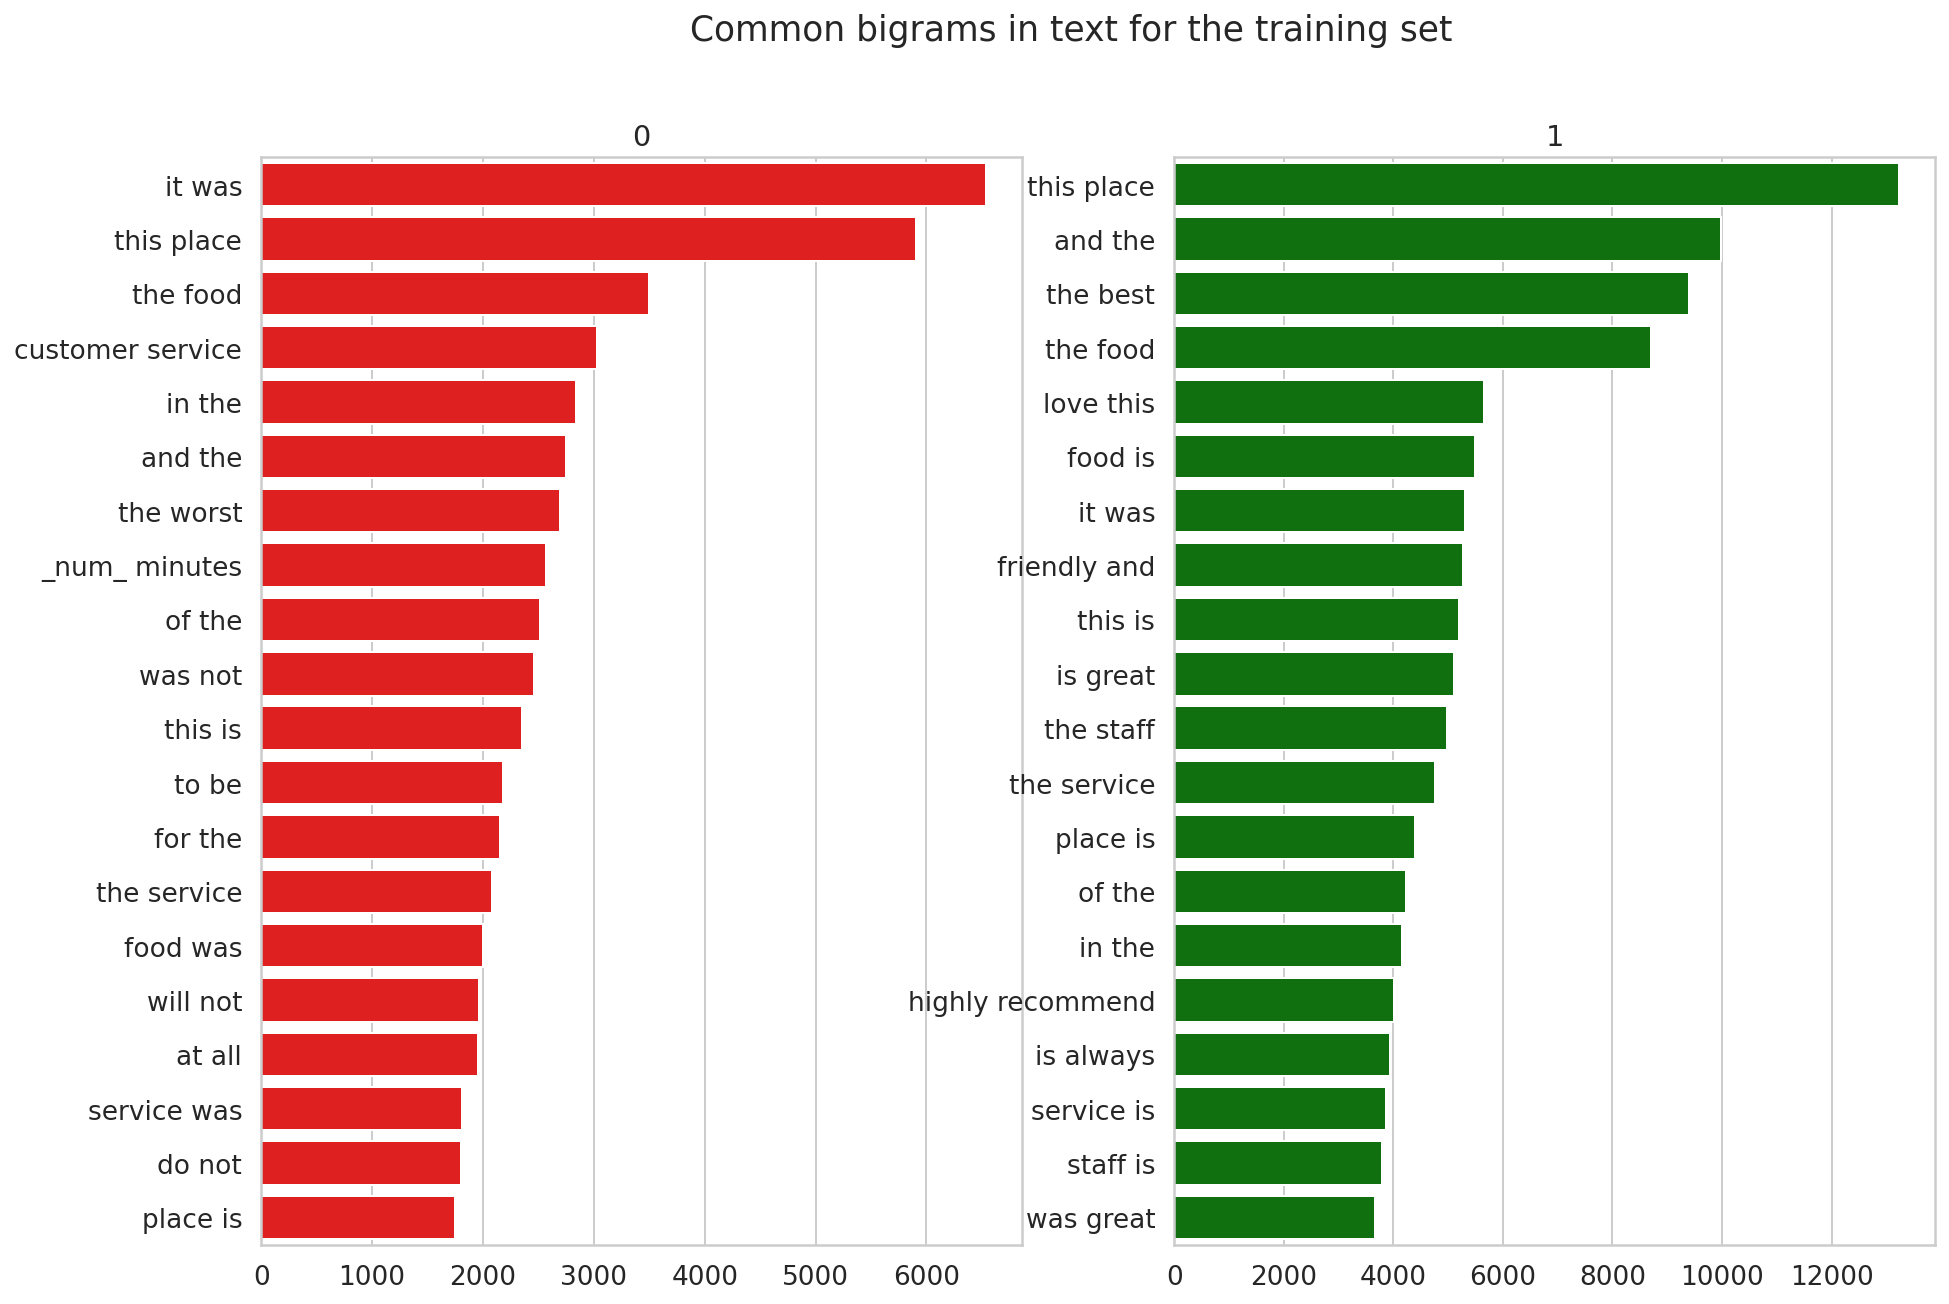

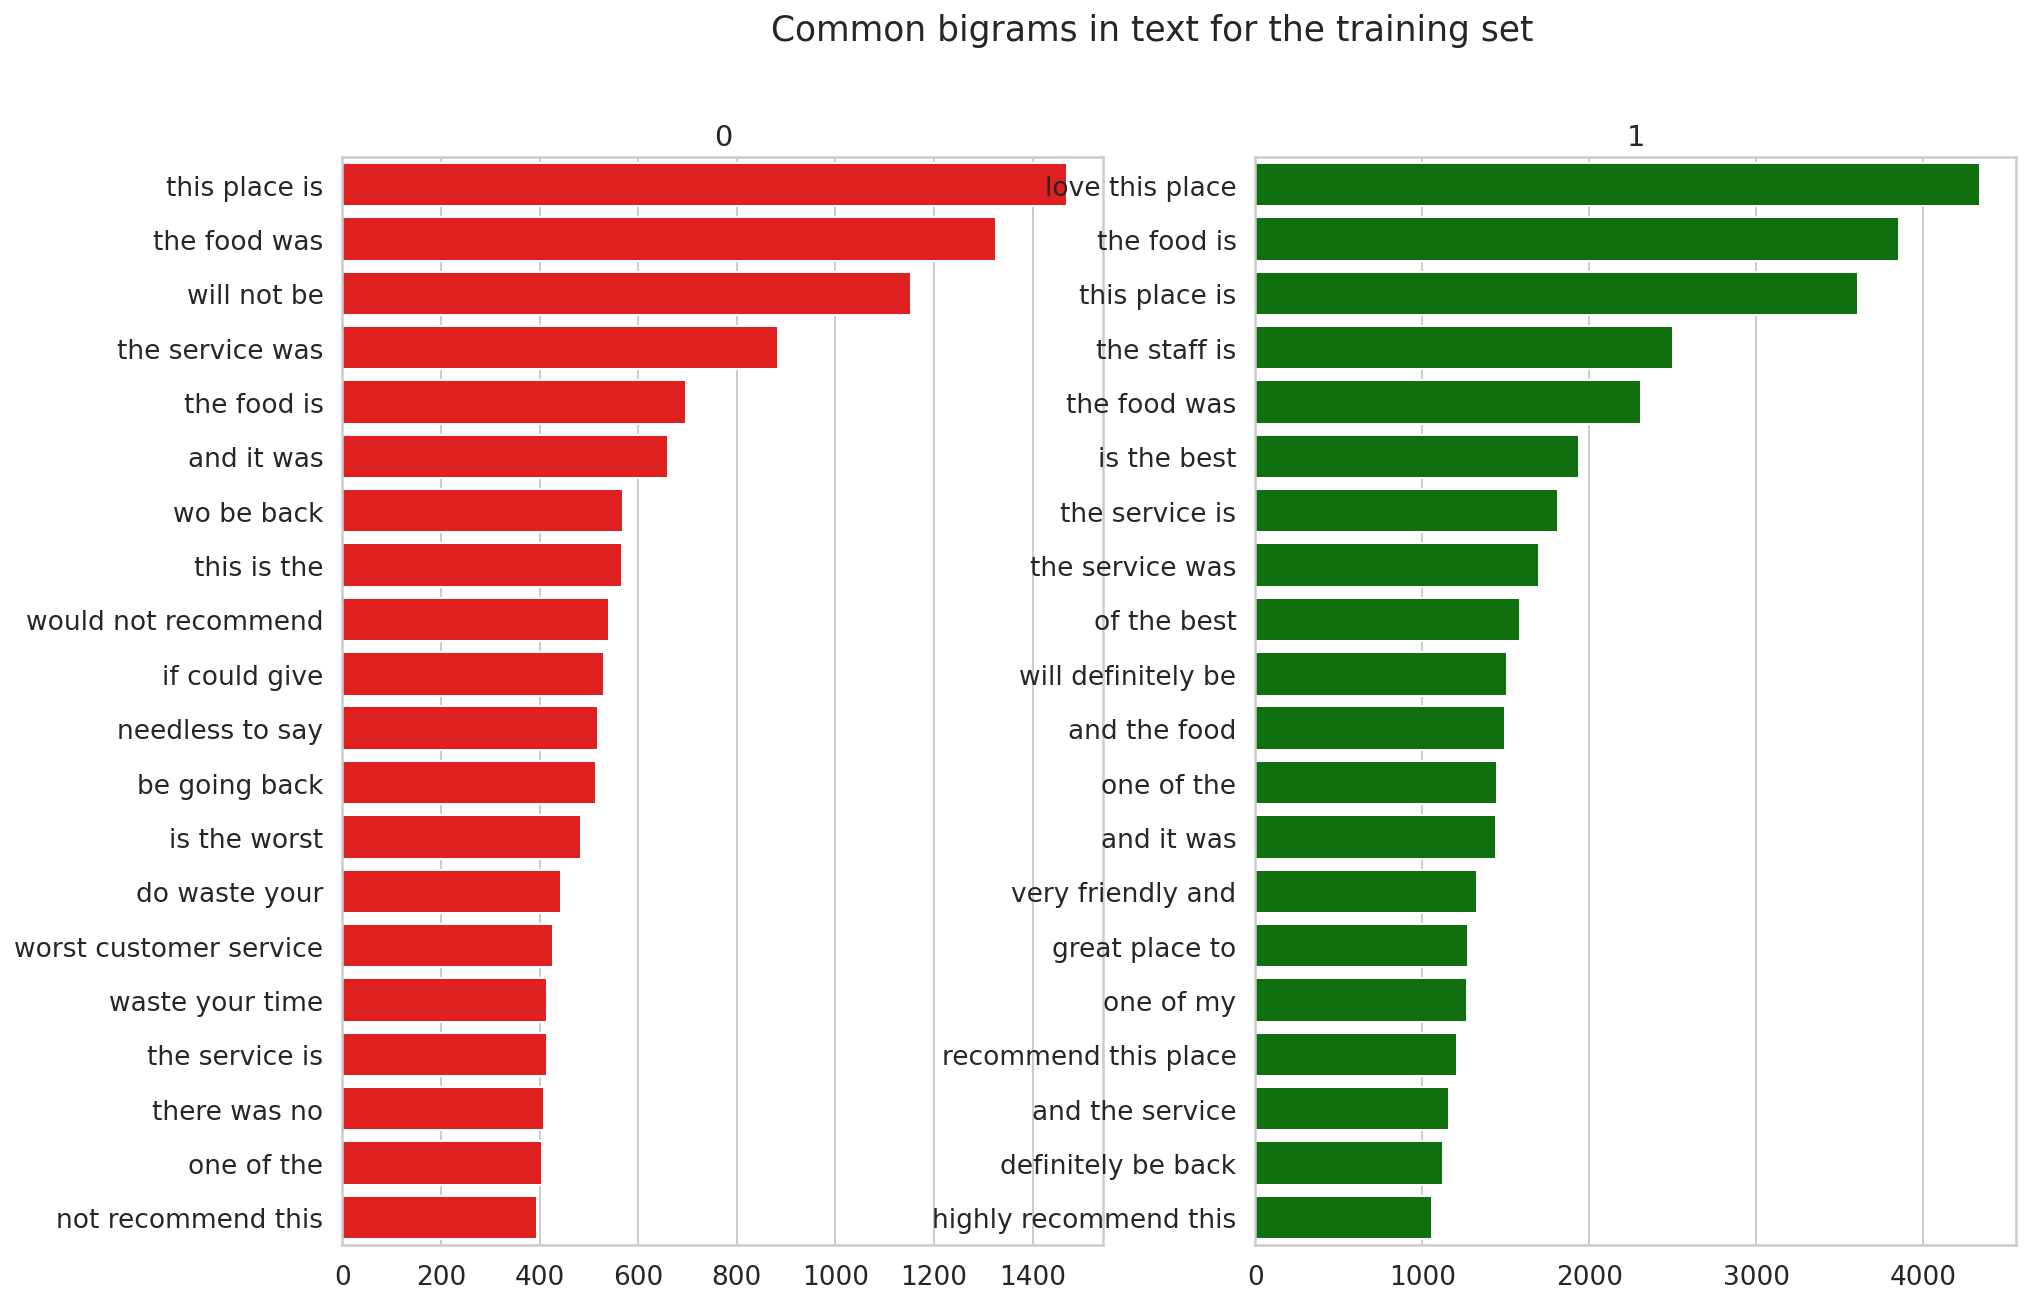

In [156]:
plot_n_grams(train_df, size=1, 
                 title="Common 1-grams in text for the training set ",
                 column="Id")

plot_n_grams(train_df, size=2, 
                 title="Common bigrams in text for the training set",
                 column="Id")

plot_n_grams(train_df, size=3, 
                 title="Common bigrams in text for the training set",
                 column="Id")


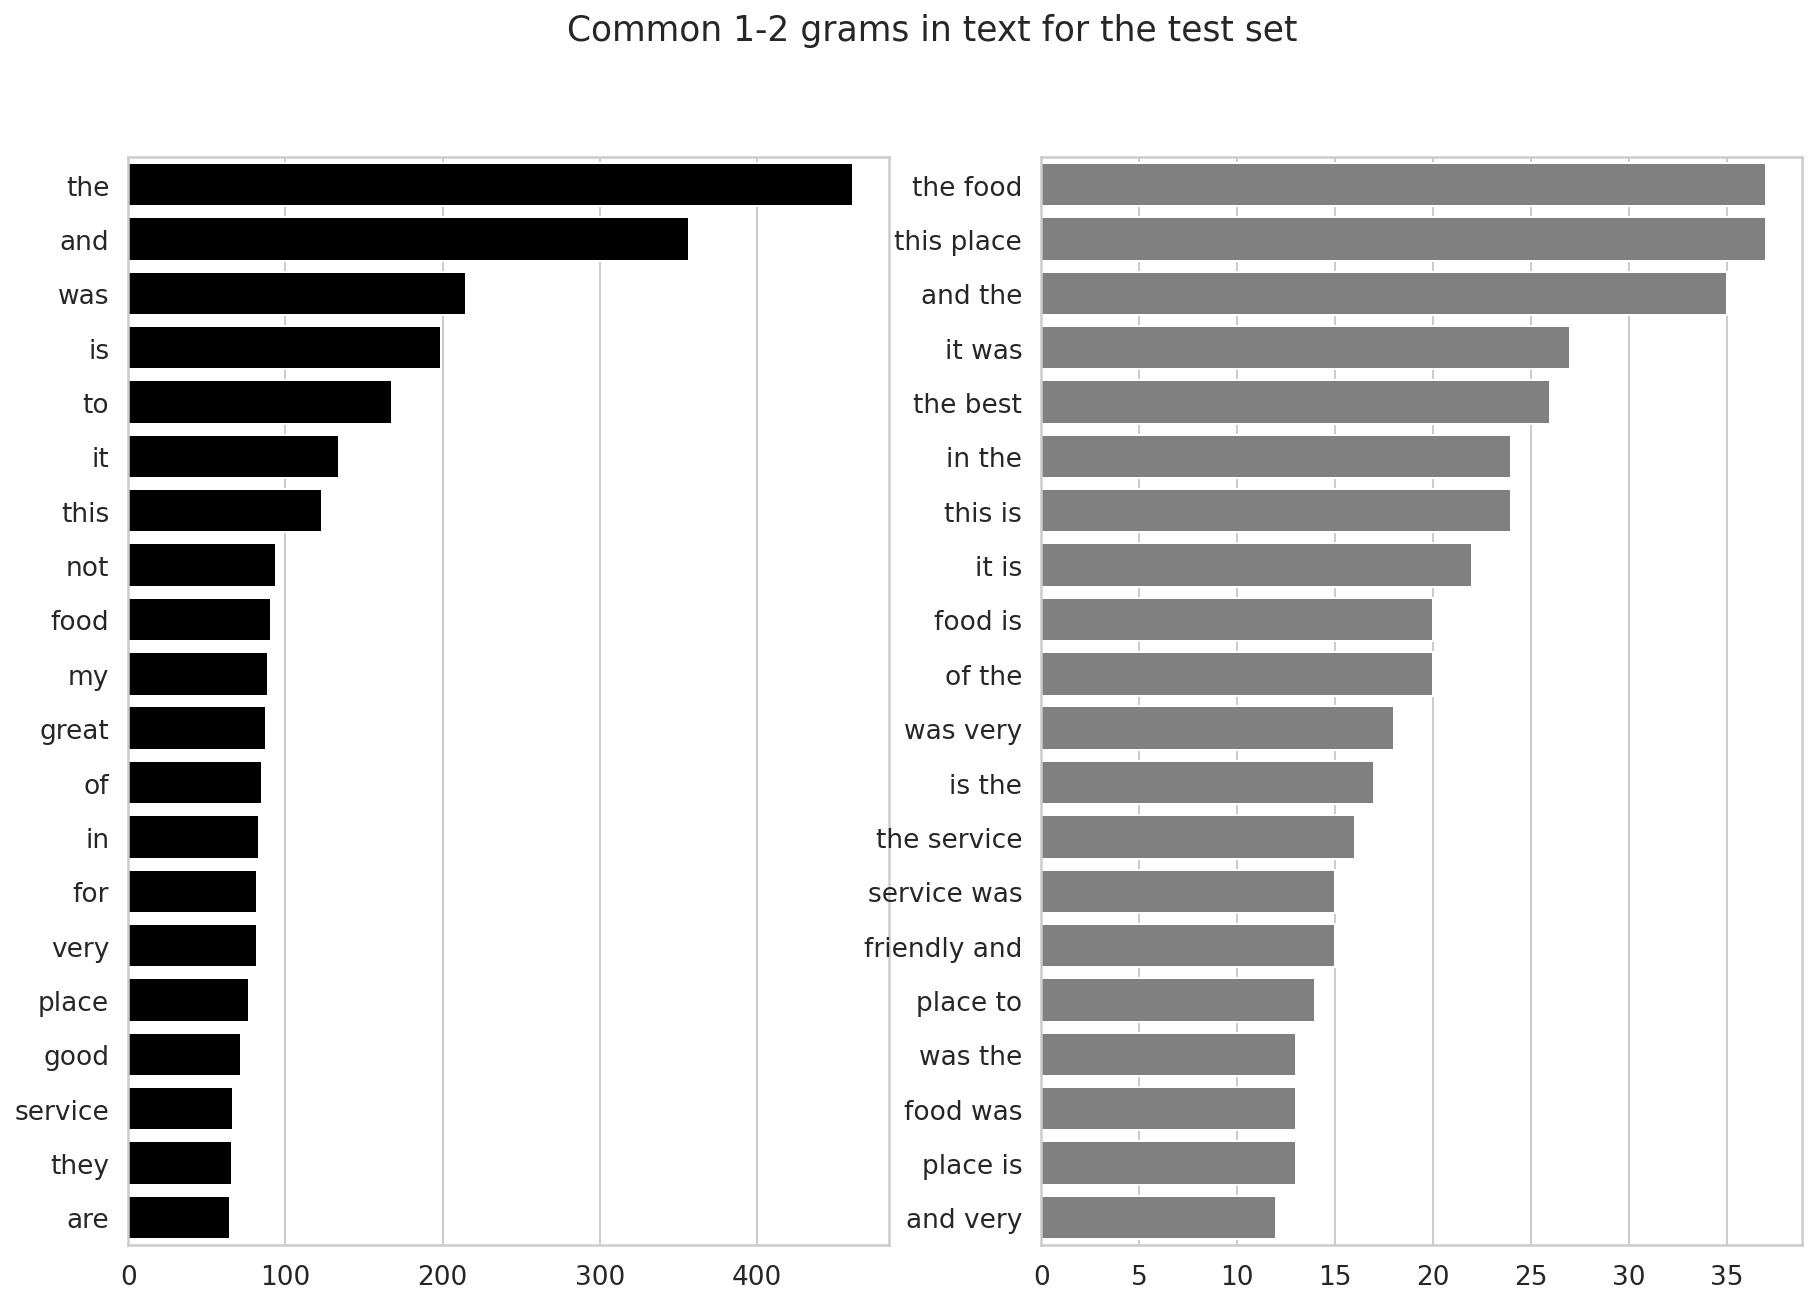

In [154]:
plot_n_grams_test(test_df, 
                 title="Common 1-2 grams in text for the test set ",
                 column="Id")



## 3. Data Preprocessing

In [ ]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]
train_df['temp_list'] = train_df['temp_list'].apply(lambda x:remove_stopword(x))

In [60]:
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = re.sub("n't"," not",text)
    text = re.sub("'s"," is",text)
    text = re.sub("'ll"," will",text)
    
    text = re.sub('!', '', text)
    #text = re.sub('.', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    return text

In [61]:
clean_text_list = []
for i, j in enumerate(tqdm(train_df.Id)):

  clean_text_list.append(clean_text(j))
train_df['Id'] = clean_text_list

  0%|          | 0/443259 [00:00<?, ?it/s]

In [62]:
clean_text_list = []
for i, j in enumerate(tqdm(val_df.Id)):

  clean_text_list.append(clean_text(j))
val_df['Id'] = clean_text_list

  0%|          | 0/4000 [00:00<?, ?it/s]

In [63]:
clean_text_list = []
for i, j in enumerate(tqdm(test_df.Id)):

  clean_text_list.append(clean_text(j))
test_df['Id'] = clean_text_list

  0%|          | 0/1000 [00:00<?, ?it/s]

In [133]:
train_df[train_df['Id']=='']
val_df[val_df['Id']=='']

,Id,label,temp_list
372,,0,[]
1676,,0,[]
2080,,1,[]
3389,,1,[]


In [72]:
train_df.head()

,Id,label,temp_list
0,i was sadly mistaken,0,"[i, was, sadly, mistaken, .]"
1,so on to the hoagies the italian is general r...,0,"[so, on, to, the, hoagies, ,, the, italian, is..."
2,minimal meat and a ton of shredded lettuce,0,"[minimal, meat, and, a, ton, of, shredded, let..."
3,nothing really special not worthy of the num...,0,"[nothing, really, special, &, not, worthy, of,..."
4,second the steak hoagie it is atrocious,0,"[second, ,, the, steak, hoagie, ,, it, is, atr..."


In [137]:

stop_sentence = []
for i, j in tqdm(enumerate(train_df.temp_list)):
  if (len(j) <= 1): 
    if ('neutral' in j) or ('negative' in j) or ('smh' in j):
      stop_sentence.append(i)

train_df = train_df.drop(list(train_df.iloc[stop_sentence].index))
train_df = train_df.drop(list(train_df[train_df['Id']==''].index))
train_df = train_df.reset_index().drop('index', axis=1)
train_df

0it [00:00, ?it/s]

,Id,label,temp_list
0,i was sadly mistaken,0,"[i, was, sadly, mistaken, .]"
1,so on to the hoagies the italian is general r...,0,"[so, on, to, the, hoagies, ,, the, italian, is..."
2,minimal meat and a ton of shredded lettuce,0,"[minimal, meat, and, a, ton, of, shredded, let..."
3,nothing really special not worthy of the num...,0,"[nothing, really, special, &, not, worthy, of,..."
4,second the steak hoagie it is atrocious,0,"[second, ,, the, steak, hoagie, ,, it, is, atr..."
...,...,...,...
442050,love these donuts,1,"[love, these, donuts, !]"
442051,lots of smiles from everyone,1,"[lots, of, smiles, from, everyone, .]"
442052,the donuts are delicious,1,"[the, donuts, are, delicious, .]"
442053,fresh in the morning and conveniently priced,1,"[fresh, in, the, morning, and, conveniently, p..."


In [138]:
stop_sentence = []
for i, j in tqdm(enumerate(val_df.temp_list)):
  if (len(j) <= 1): 
    if ('neutral' in j) or ('negative' in j) or ('smh' in j):
      stop_sentence.append(i)

val_df = val_df.drop(list(val_df.iloc[stop_sentence].index))
val_df = val_df.drop(list(val_df[val_df['Id']==''].index))
val_df = val_df.reset_index().drop('index', axis=1)
val_df

0it [00:00, ?it/s]

,Id,label,temp_list
0,windows have not been cleaned in years you ca...,0,"[windows, have, not, been, cleaned, in, years,..."
1,waitresses are slow,0,"[waitresses, are, slow]"
2,just a mess avoid at all costs,0,"[just, a, mess, avoid, at, all, costs]"
3,bad,0,[bad]
4,now pizza is beyond awful and wings are down t...,0,"[now, pizza, is, beyond, awful, and, wings, ar..."
...,...,...,...
3985,really love this place,1,"[really, love, this, place]"
3986,i recently moved in the area and was looking f...,1,"[i, recently, moved, in, the, area, and, was, ..."
3987,this place is amazing,1,"[this, place, is, amazing]"
3988,true authentic italian deli,1,"[true, authentic, italian, deli]"


In [83]:
stop_sentence = []
for i, j in tqdm(enumerate(test_df.temp_list)):
  if len(j) == 1:
    stop_sentence.append(i)
test_df.iloc[stop_sentence]

0it [00:00, ?it/s]

,Id,temp_list


In [93]:
stoken_list =[]
for i, j in enumerate(test_df.Id):
   if "smh" in j:
     stoken_list.append(i)

test_df.iloc[stoken_list]

,Id,temp_list


In [78]:
pd.unique(train_df.iloc[stop_sentence].Id)

array(['neutral', 'negative', '', 'positive', 'ok', 'smh', 'wow',
       'amazing', 'delicious', 'friendly', 'well'], dtype=object)

train dataset에서 단어 개수가 한개인 것들 중에서 test에 존재하지 않는 단어 : neutral, negative, smh, wow
그리고 clean_text 함수 적용결과 빈텍스트 데이터를 제외한다.

n't -> not
's -> is
'll -> will

변경한다

## 4. model

In [141]:
class BaseDataset(Dataset):
  def __init__(self, df, tokenizer, max_len):
    self.df = df
    self.tokenizer = tokenizer
    self.max_len = max_len
    if 'label' in df:
      self.labeled=True
      self.targets = df.label.to_numpy()
    else:
      self.labeled=False

    
  def __len__(self):
    return len(self.df)

  def __getitem__(self, item):
    review = str(self.df['Id'][item])

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    if self.labeled:
      target = torch.tensor(self.targets[item], dtype=torch.long)    

    return {'review_text': review, 'input_ids': encoding['input_ids'].flatten(),'attention_mask': encoding['attention_mask'].flatten(),'targets': target} if self.labeled else {'review_text': review, 'input_ids': encoding['input_ids'].flatten(),'attention_mask': encoding['attention_mask'].flatten()}

In [ ]:
test_data_loader = DataLoader(BaseDataset(test_df, tokenizer, 25), batch_size=128)

In [ ]:
data = next(iter(test_data_loader))
data.keys()

In [ ]:
data

In [142]:
class ReadabilityModel(pl.LightningModule):

  def __init__(self):
    super().__init__()
    self.Roberta = RobertaForSequenceClassification.from_pretrained(MODEL_NAME)

  def forward(self, input_ids, attention_mask, labels=None):

    output = self.Roberta(
    input_ids=input_ids,
    attention_mask=attention_mask
    )
    if labels is not None:
      output = self.Roberta(
      input_ids=input_ids,
      attention_mask=attention_mask,
      labels=labels
      )
      return output
    return output
    

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["targets"]
    outputs = self(input_ids, attention_mask, labels)
    loss = outputs.loss

    self.log("train_loss", loss, prog_bar=True, logger=True)
    return loss
    
  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["targets"]
    outputs = self(input_ids, attention_mask, labels)
    loss = outputs.loss

    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss


  def configure_optimizers(self):
    optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
        #lr_scheduler = get_constant_schedule_with_warmup(optimizer, 100)
    return optimizer
    


In [62]:
train_df=train_df.reset_index().drop('index',axis=1)
val_df = val_df.reset_index().drop('index', axis=1)

In [143]:
BATCH_SIZE = 64
MAX_LEN = 25

train_data_loader = DataLoader(BaseDataset(train_df, tokenizer, MAX_LEN),  batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_data_loader = DataLoader(BaseDataset(val_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_data_loader = DataLoader(BaseDataset(test_df, tokenizer, MAX_LEN), batch_size=1000, shuffle=False, num_workers=2)

In [144]:
model = ReadabilityModel()

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifie

In [145]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

checkpoint_callback = ModelCheckpoint(
    filename="/content/drive/MyDrive/Colab Notebooks/LG_project/data",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min")


In [146]:
trainer = pl.Trainer(
    # logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=15,
    gpus=1,
    progress_bar_refresh_rate=30)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_data_loader, val_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                             | Params
-------------------------------------------------------------
0 | Roberta | RobertaForSequenceClassification | 355 M 
-------------------------------------------------------------
355 M     Trainable params
0         Non-trainable params
355 M     Total params
1,421.447 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

In [64]:
trained_model = ReadabilityModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
) 

trained_model.freeze()

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classi

In [145]:
data = next(iter(test_data_loader))

In [146]:
input_ids = data['input_ids']
attention_mask = data['attention_mask']


output = trained_model(input_ids=input_ids,
                       attention_mask=attention_mask)

output.logits
batch_predictions = [0 if example[0] > example[1] else 1 for example in output.logits]
len(batch_predictions)

1000

In [147]:
test_df['Category'] = batch_predictions

In [148]:
test_df

,Id,temp_list,Category
0,it 's a whole new experience and new flavors e...,"[it, 's, a, whole, new, experience, and, new, ...",1
1,so disappointing from an old favorite .,"[so, disappointing, from, an, old, favorite, .]",0
2,it is the most authentic thai in the valley .,"[it, is, the, most, authentic, thai, in, the, ...",1
3,do not sign a lease with these people .,"[do, not, sign, a, lease, with, these, people, .]",0
4,i was nervous and she made me feel so comforta...,"[i, was, nervous, and, she, made, me, feel, so...",1
...,...,...,...
995,the food here is delicious .,"[the, food, here, is, delicious, .]",1
996,we 'll certainly be back !,"[we, 'll, certainly, be, back, !]",1
997,the building itself looks abandoned .,"[the, building, itself, looks, abandoned, .]",0
998,if i could give zero stars i def would .,"[if, i, could, give, zero, stars, i, def, woul...",0


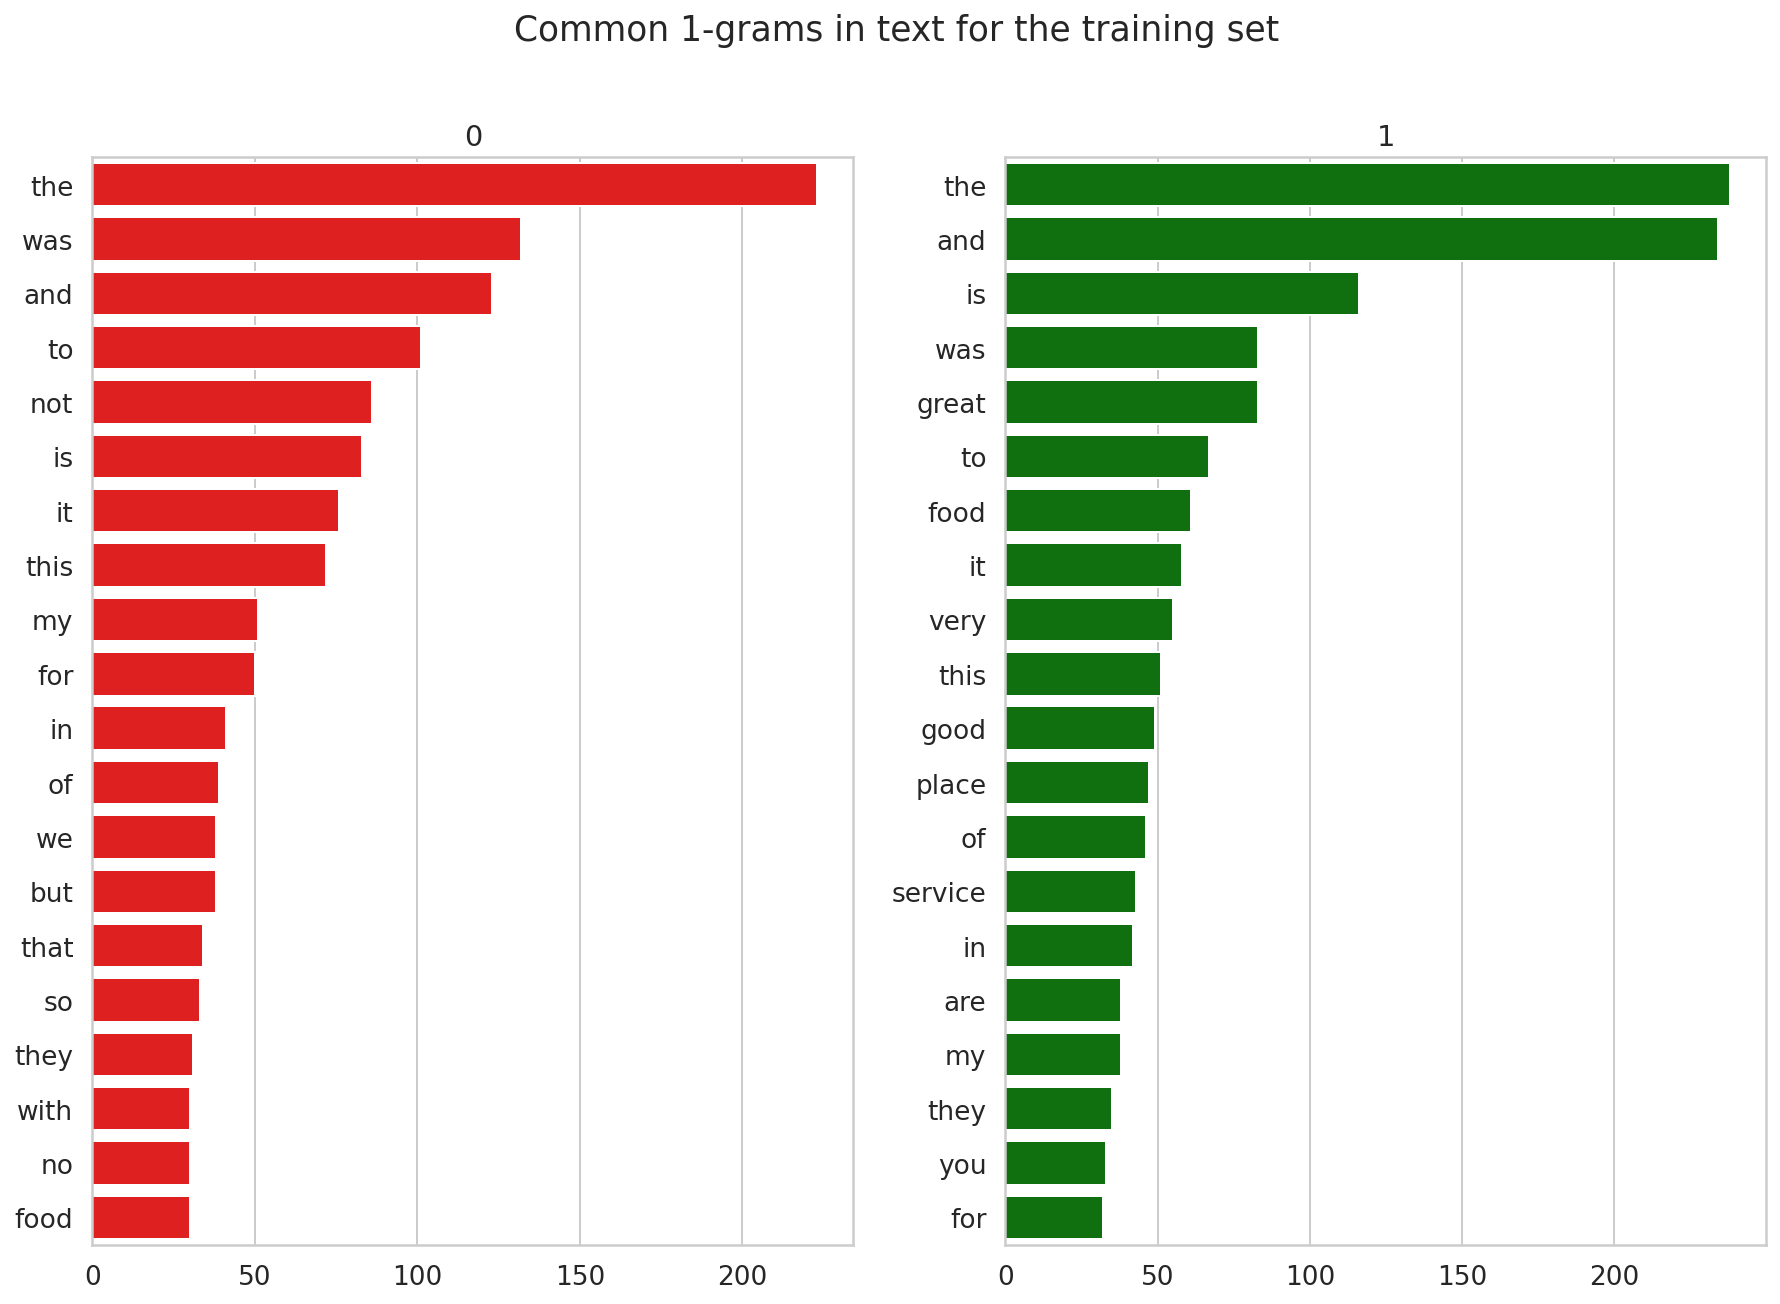

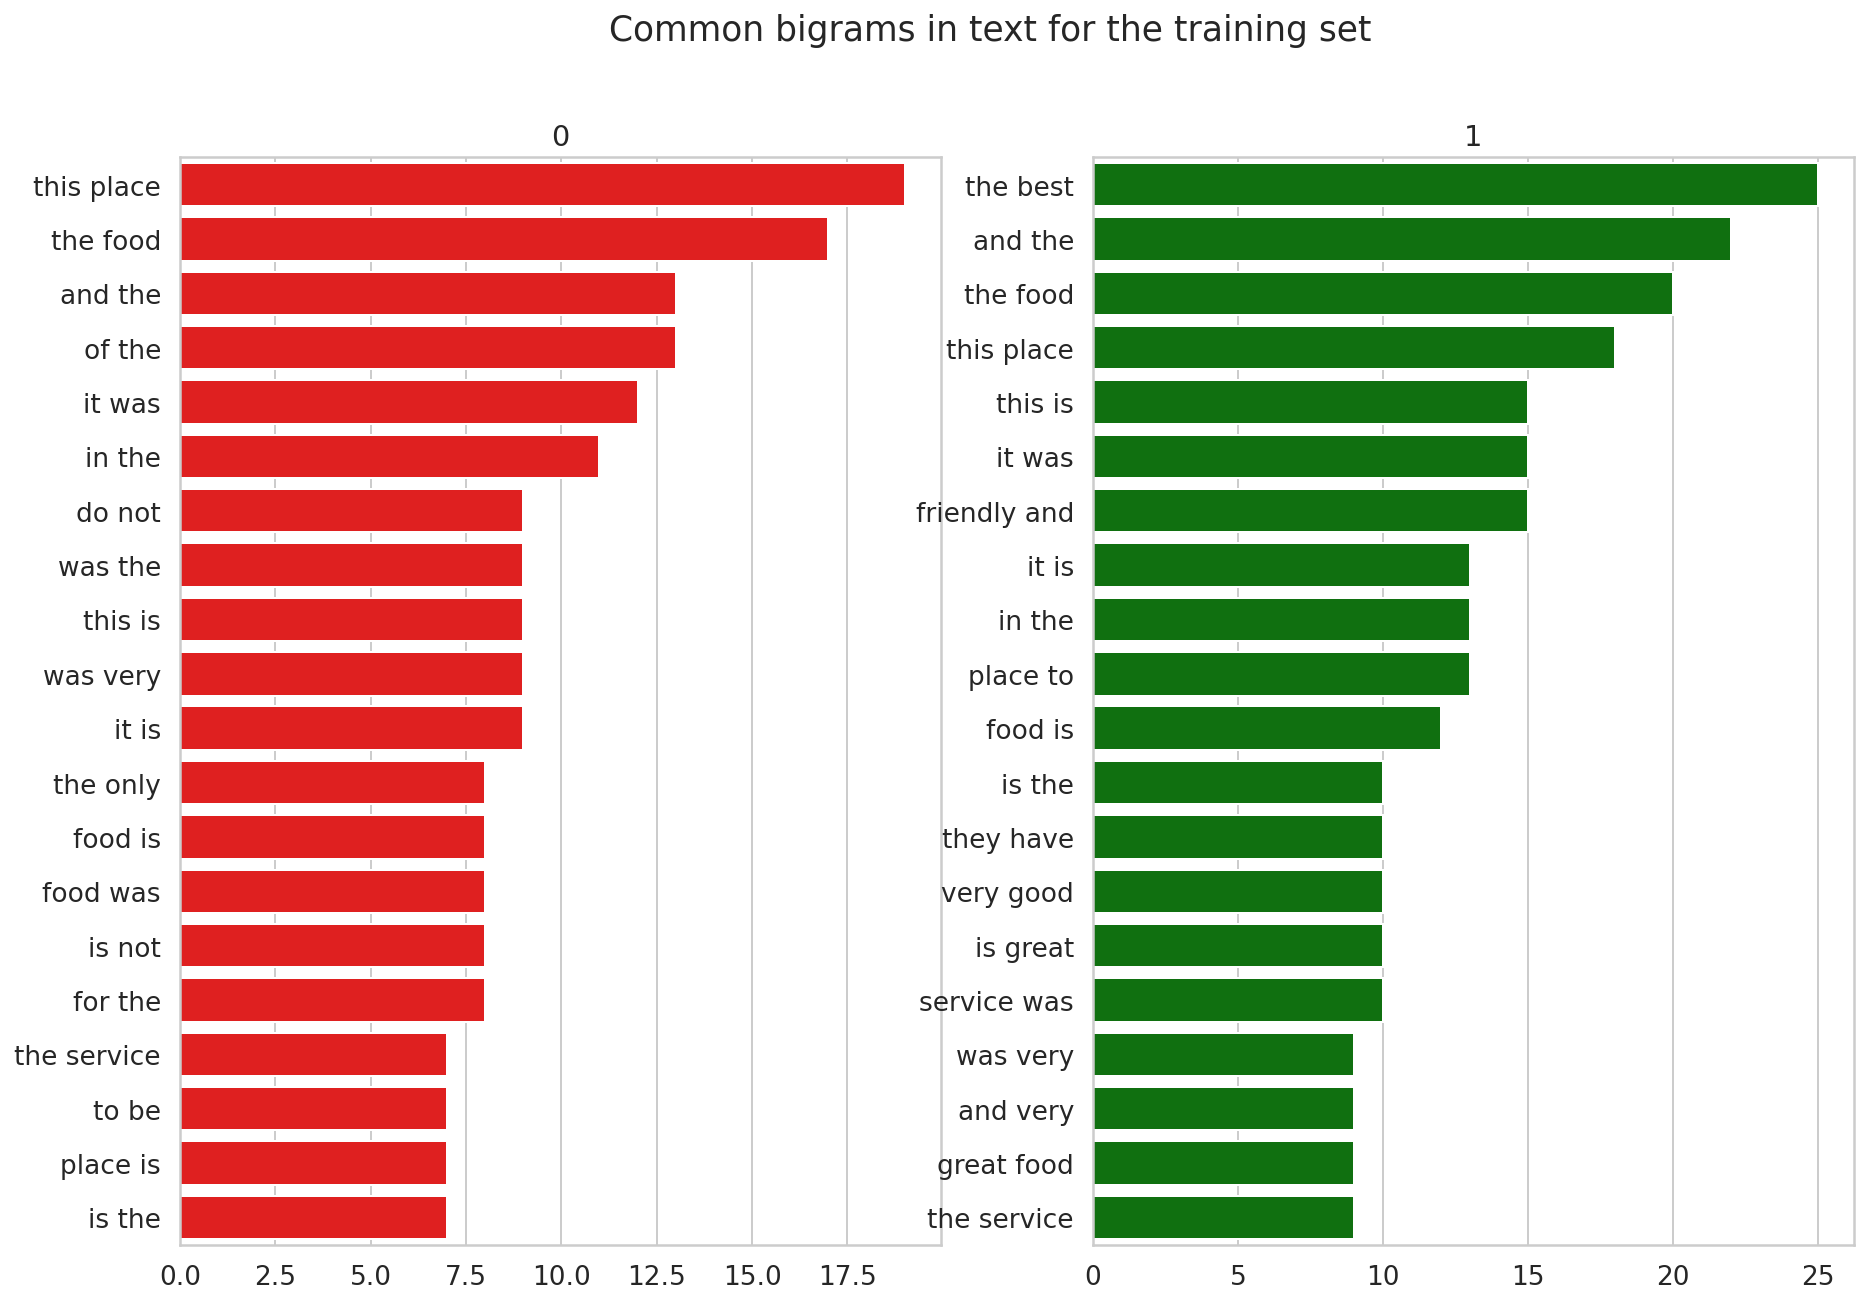

In [155]:
plot_n_grams(test_df, size=1, 
                 title="Common 1-grams in text for the training set ",
                 label='Category',
                 column="Id")

plot_n_grams(test_df, size=2, 
                 title="Common bigrams in text for the training set",
             label='Category',
                 column="Id")


In [ ]:
test_df.to_csv('/content/drive/MyDrive/Colab Notebooks/goormtextclassificationproject/submission_roberta_large_batch_100.csv', index=False)


validation_data에서 확인


In [65]:
visual_val_df = DataLoader(BaseDataset(val_df, tokenizer, MAX_LEN), batch_size=4000, shuffle=False, num_workers=2)

In [66]:
data = next(iter(visual_val_df))
input_ids = data['input_ids']
attention_mask = data['attention_mask']


output = trained_model(input_ids=input_ids,
                       attention_mask=attention_mask)

output.logits
batch_predictions = [0 if example[0] > example[1] else 1 for example in output.logits]
len(batch_predictions)

4000

In [67]:
val_df['Category'] = batch_predictions

In [69]:
val_df

,Id,label,temp_list,Category
0,windows have n't been cleaned in years you can...,0,"[windows, have, n't, been, cleaned, in, years,...",0
1,waitresses are slow .,0,"[waitresses, are, slow, .]",0
2,just a mess avoid at all costs !,0,"[just, a, mess, avoid, at, all, costs, !]",0
3,bad !,0,"[bad, !]",0
4,now pizza is beyond awful and wings are down t...,0,"[now, pizza, is, beyond, awful, and, wings, ar...",0
...,...,...,...,...
3995,really love this place .,1,"[really, love, this, place, .]",1
3996,i recently moved in the area and was looking f...,1,"[i, recently, moved, in, the, area, and, was, ...",1
3997,this place is amazing !,1,"[this, place, is, amazing, !]",1
3998,true authentic italian deli .,1,"[true, authentic, italian, deli, .]",1


In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix(val_df.label, val_df.Category)

array([[1969,   31],
       [  29, 1971]])

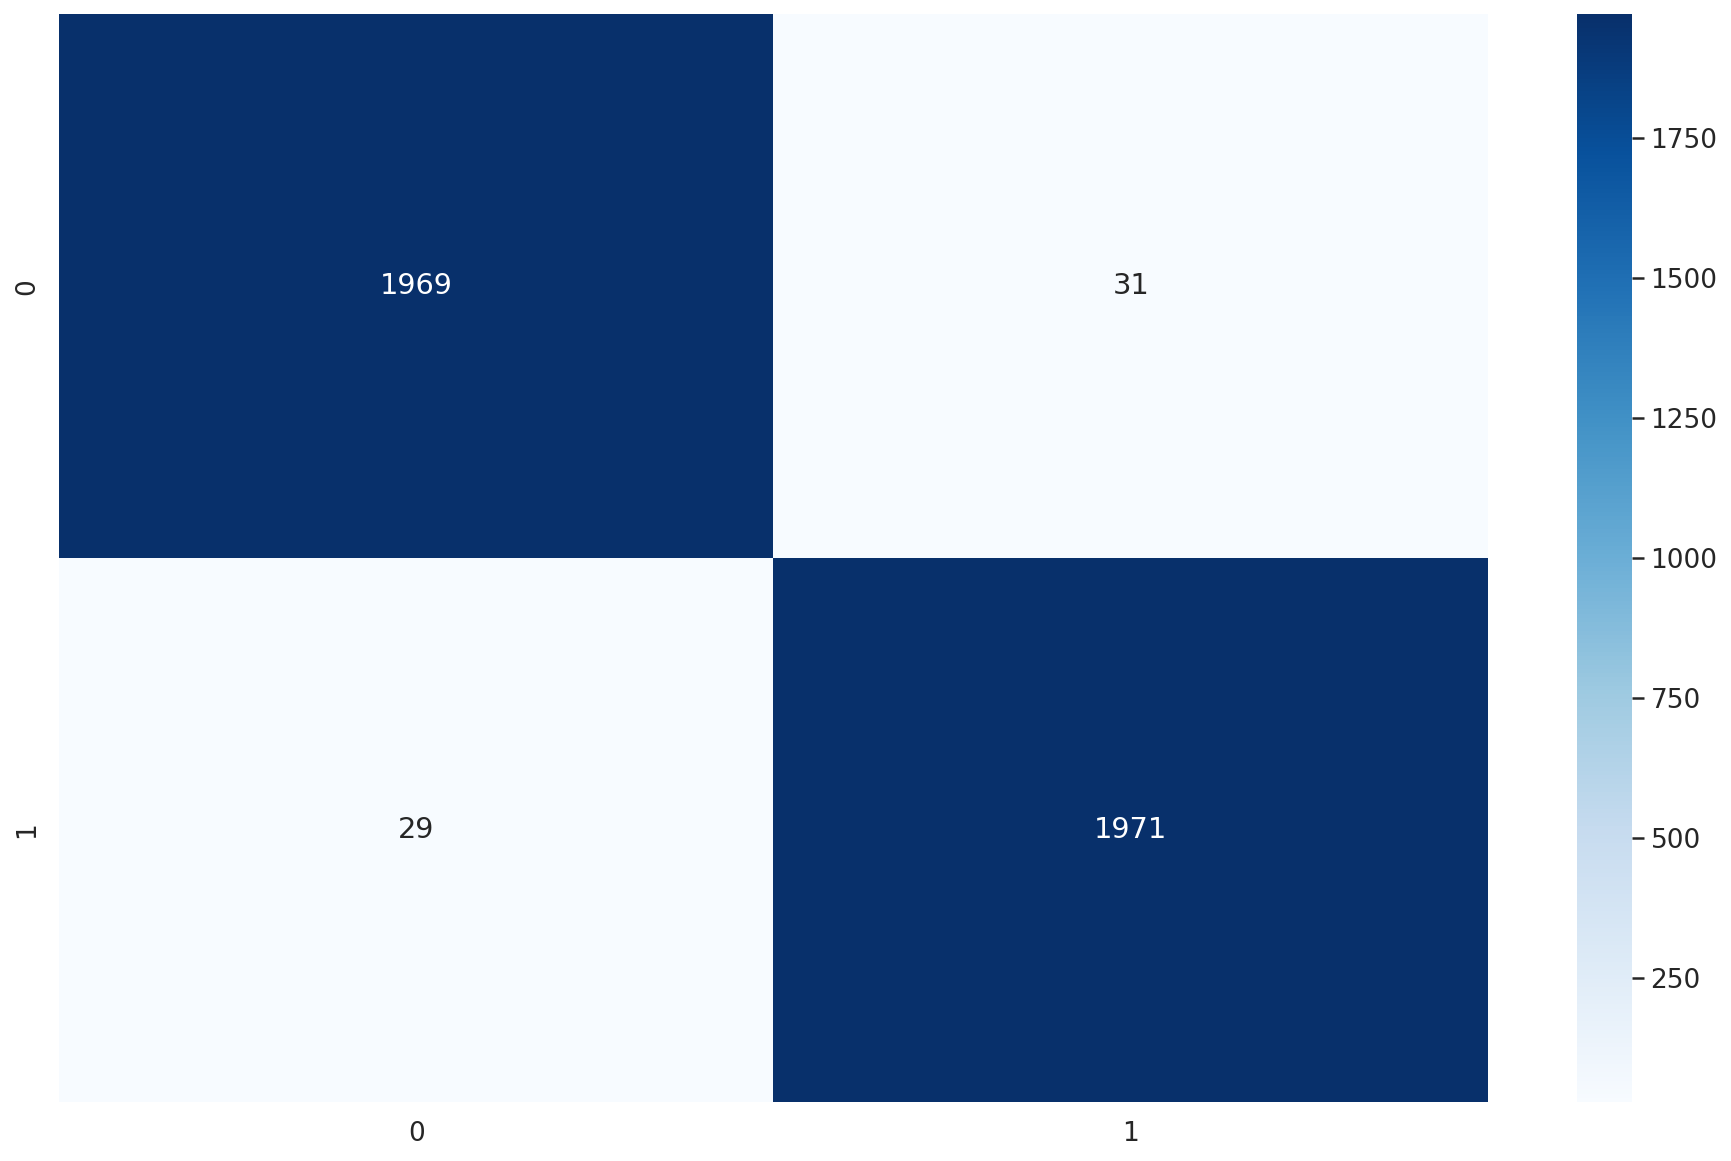

In [70]:
sns.heatmap(data=confusion_matrix(val_df.label, val_df.Category), annot=True, fmt='d', cmap='Blues')

In [71]:
import sklearn.metrics as metrics

print('accuracy', metrics.accuracy_score(val_df.label,val_df.Category) )

print('precision', metrics.precision_score(val_df.label,val_df.Category) )

print('recall', metrics.recall_score(val_df.label,val_df.Category) )

print('f1', metrics.f1_score(val_df.label,val_df.Category) )

accuracy 0.985
precision 0.9845154845154845
recall 0.9855
f1 0.985007496251874


In [72]:
val_df[val_df['label']!=val_df['Category']]

,Id,label,temp_list,Category
55,it always feels crowded .,0,"[it, always, feels, crowded, .]",1
103,phoenix az ... .,0,"[phoenix, az, ..., .]",1
269,the bathrooms were very clean and the booth we...,0,"[the, bathrooms, were, very, clean, and, the, ...",1
272,"i spoke with a manager , erica martin about ou...",0,"[i, spoke, with, a, manager, ,, erica, martin,...",1
343,the star is for me and my seasoning additions !,0,"[the, star, is, for, me, and, my, seasoning, a...",1
402,"so , this place was perfect to just sleep and ...",0,"[so, ,, this, place, was, perfect, to, just, s...",1
408,"yelp is my review , my story , and my life .",0,"[yelp, is, my, review, ,, my, story, ,, and, m...",1
421,they deserve a star .,0,"[they, deserve, a, star, .]",1
438,the service was friendly and the food was n't ...,0,"[the, service, was, friendly, and, the, food, ...",1
547,husband ordered the ribeye and it too was cook...,0,"[husband, ordered, the, ribeye, and, it, too, ...",1


In [78]:
stoken_list =[]
for i, j in enumerate(train_df.Id):
   if 'not' in j:
     stoken_list.append(i)


In [79]:
train_df.iloc[stoken_list]

,Id,label,temp_list
3,nothing really special & not worthy of the $ _...,0,"[nothing, really, special, &, worthy, $, _num_..."
8,i was not going to pay for the dressing on the...,0,"[going, pay, dressing, side, .]"
21,we will not be back .,0,"[back, .]"
32,"not a call , not the estimate , nothing .",0,"[call, ,, estimate, ,, nothing, .]"
35,at this point they were open and would be for ...,0,"[point, open, would, another, hour, .]"
...,...,...,...
442912,"this place has good portions , good food , and...",1,"[place, good, portions, ,, good, food, ,, bad,..."
442970,small little shop but the customer service and...,1,"[small, little, shop, customer, service, food,..."
442980,"i am not a big meat eater but , this burger wa...",1,"[big, meat, eater, ,, burger, really, good, .]"
443144,it 's nothing fancy but it hits the spot .,1,"['s, nothing, fancy, hits, spot, .]"


In [80]:
stoken_list =[]
for i, j in enumerate(train_df.Id):
   if "n't" in j:
     stoken_list.append(i)

train_df.iloc[stoken_list]

,Id,label,temp_list
31,do n't waste your time .,0,"[n't, waste, time, .]"
46,i would n't use their services again if you pa...,0,"[would, n't, use, services, paid, .]"
48,"bread or not , it still was n't great .",0,"[bread, ,, still, n't, great, .]"
52,just do n't go hungry if you actually have tas...,0,"[n't, go, hungry, actually, tastebuds, .]"
59,"guess who was n't too busy , carnegie coffee c...",0,"[guess, n't, busy, ,, carnegie, coffee, compan..."
...,...,...,...
441453,it 's good stuff and they ca n't keep up with ...,1,"['s, good, stuff, ca, n't, keep, demand, !]"
442063,ca n't wait for next time - keep up the great ...,1,"[ca, n't, wait, next, time, -, keep, great, wo..."
442109,"i recommend this place , even though i have n'...",1,"[recommend, place, ,, even, though, n't, eaten..."
442551,they give you a fair price and do n't overchar...,1,"[give, fair, price, n't, overcharge, things, .]"


In [ ]:
train_df
print(train_df[train_df['Id']=='!'])



In [ ]:
print(train_df[train_df['Id']=='neutral'])

In [73]:

set(test_df.Id).intersection(set(val_df.Id))

{'we will not be coming back .'}

In [81]:
test_df

,Id,temp_list
0,it 's a whole new experience and new flavors e...,"[it, 's, a, whole, new, experience, and, new, ..."
1,so disappointing from an old favorite .,"[so, disappointing, from, an, old, favorite, .]"
2,it is the most authentic thai in the valley .,"[it, is, the, most, authentic, thai, in, the, ..."
3,do not sign a lease with these people .,"[do, not, sign, a, lease, with, these, people, .]"
4,i was nervous and she made me feel so comforta...,"[i, was, nervous, and, she, made, me, feel, so..."
...,...,...
995,the food here is delicious .,"[the, food, here, is, delicious, .]"
996,we 'll certainly be back !,"[we, 'll, certainly, be, back, !]"
997,the building itself looks abandoned .,"[the, building, itself, looks, abandoned, .]"
998,if i could give zero stars i def would .,"[if, i, could, give, zero, stars, i, def, woul..."
